In [1]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show


In [2]:
import torch
from math import sqrt 

In [3]:
from torch import nn
from transformers import AutoConfig

In [4]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text =  "Chicken crossed the street because it was too scared"
show(model, "bert", tokenizer, text, display_mode="dark", layer=0, head=8)

/opt/miniconda3/envs/transformers/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/miniconda3/envs/transformers/lib/python3.12/site-packages/bertviz/transformers_neuron_view/modeling_utils.py:482: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Understanding Queries, Key and Values

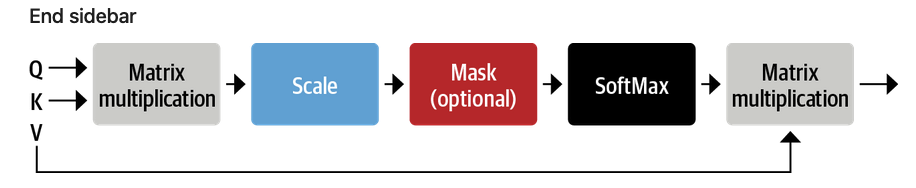

In [5]:
model_ckpt = "bert-base-uncased"
text = "Chicken crossed the street because it was too scared"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [6]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[7975, 4625, 1996, 2395, 2138, 2009, 2001, 2205, 6015]])

In [7]:
config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)

In [8]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()

torch.Size([1, 9, 768])

In [9]:
inputs_embeds.size()

torch.Size([1, 9, 768])

#### Toy Implementation of Attention

In [10]:
query = key = value = inputs_embeds

In [11]:
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
scores.size()

torch.Size([1, 9, 9])

In [12]:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [13]:
weights

tensor([[[1.0000e+00, 2.9819e-13, 5.7132e-13, 1.0389e-12, 6.0725e-13,
          6.5208e-13, 8.6617e-14, 4.0584e-13, 2.2788e-13],
         [1.8885e-12, 1.0000e+00, 4.9204e-12, 3.3862e-12, 2.8313e-12,
          3.5765e-12, 8.6122e-13, 5.5172e-13, 1.2473e-11],
         [1.2201e-12, 1.6592e-12, 1.0000e+00, 1.0343e-12, 6.8844e-13,
          1.0277e-13, 3.0916e-12, 1.7534e-12, 2.1970e-12],
         [1.6896e-11, 8.6951e-12, 7.8764e-12, 1.0000e+00, 1.2805e-12,
          5.0796e-12, 2.1615e-12, 4.3725e-12, 9.1749e-12],
         [1.2471e-12, 9.1807e-13, 6.6202e-13, 1.6170e-13, 1.0000e+00,
          6.5222e-13, 1.7342e-13, 4.2761e-12, 5.3997e-12],
         [5.6497e-13, 4.8926e-13, 4.1692e-14, 2.7061e-13, 2.7516e-13,
          1.0000e+00, 1.7870e-13, 6.0847e-13, 4.0121e-13],
         [4.6833e-14, 7.3523e-14, 7.8271e-13, 7.1862e-14, 4.5659e-14,
          1.1152e-13, 1.0000e+00, 9.7945e-13, 8.2128e-14],
         [3.0898e-13, 6.6323e-14, 6.2509e-13, 2.0470e-13, 1.5853e-12,
          5.3468e-13, 1.379

In [14]:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 9, 768])

In [15]:
query.size(-1)

768

In [16]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)


In [17]:
key.shape

torch.Size([1, 9, 768])

In [18]:
v = nn.Softmax(dim=1)

In [19]:
chk = torch.tensor([[10., 15.]])

In [20]:
chk.shape

torch.Size([1, 2])

### Implementing Single Attention Head

In [21]:
class AttentionHead(nn.Module):

    def __init__(self, embed_dim , head_dim):
        super().__init__()

        ## Projection of Embedding / Hidden State in Query, Key, Value Matrix
        ## nn.Linear is doing matrix multiplication
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(self.q(hidden_state),
                                                    self.k(hidden_state),
                                                    self.v(hidden_state))
        return attn_outputs

### MultiHead Attention Implementation

In [22]:
class MultiHeadAttention(nn.Module):
    ## represent params for bert uncased
    def __init__(self, config):
        super().__init__()

        embed_dim = config.hidden_size ## 768 Embedding Dimensions
        num_heads = config.num_attention_heads ## 12 Heads
        head_dim = embed_dim // num_heads ## 64 

        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
            )
        
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):

        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)

        return x

### Testing

In [23]:
multihead_attn = MultiHeadAttention(config)

In [24]:
inputs_embeds.size()

torch.Size([1, 9, 768])

In [25]:
attn_output = multihead_attn(inputs_embeds)

In [26]:
attn_output.shape

torch.Size([1, 9, 768])

### Attention Visualization 

Use of 1 word in two different sentences with different contexts

`time flies like an arrow. Fruit flies like a banana`

In [27]:
from transformers import AutoModel
from bertviz import head_view

In [28]:
model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [29]:
sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')

In [30]:
attention = model(**viz_inputs).attentions

sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>

### FeedForward Layer (Position Wide Feed Forward Layer)

In [31]:
class FeedForward(nn.Module):

    def __init__(self, config):

        super().__init__()

        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)

        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)

        self.gelu = nn.GELU()
        
        self.dropout = nn.Dropout(config.hidden_dropout_prob)


    def forward(self, x):

        x = self.linear_1(x)

        x = self.gelu(x)

        x = self.linear_2(x)

        x = self.dropout(x)

        return x
  
     


In [32]:
feed_forward = FeedForward(config=config)
ff_outputs = feed_forward(attn_output)

In [33]:
ff_outputs.size()

torch.Size([1, 9, 768])

### Adding Layer Normalization

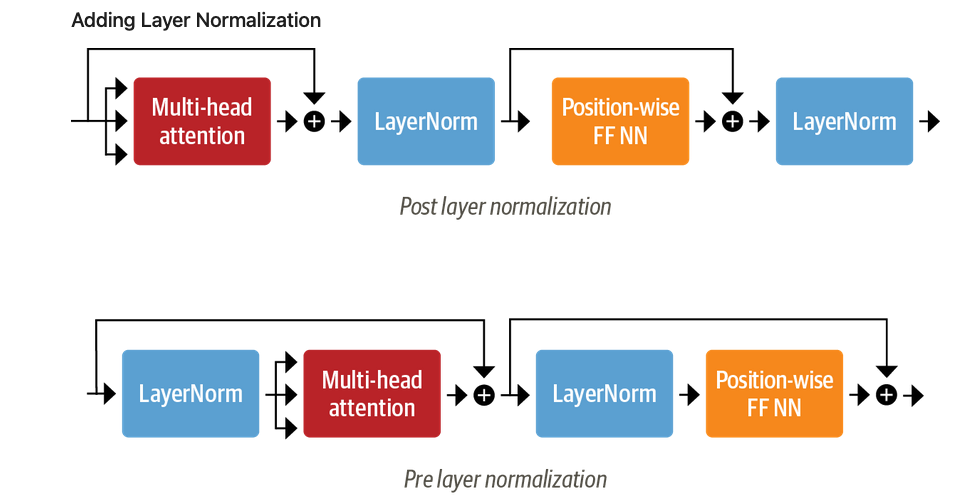

#### Pre Layer Normalisation Code

In [34]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)

        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)


    def forward(self, x):
        
        # x is hidden state from previous Encoder Block #
        hidden_state_norm = self.layer_norm_1(x)

        # self attention on normalised hidden state
        x_attn = self.attention(hidden_state_norm)

        # Apply skip connection to `x_attn` with `hidden_state_norm`
        layer_norm_mha_skip_connect = x + x_attn

        # Applying 2nd layer normalisation

        layer_norm_pre_ffcn = self.layer_norm_2(layer_norm_mha_skip_connect)

        ffcn_output = self.feed_forward(layer_norm_pre_ffcn)

        return ffcn_output

#### Post Layer Normalisation Code

In [35]:
class TransformerEncoderLayerPostLayerNorm(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)

        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)


    def forward(self, x):

        # Self Attention Output #
        x_attn = self.attention(x)

        # attention_out with skip connection using hidden state
        x_attn_skip = x + x_attn

        # Applying 1st Layer Norm 
        x_attn_skip_layer_norm = self.layer_norm_1(x_attn_skip)

        # Passing Layer norm to ffcn
        ffcn_output = self.feed_forward(x_attn_skip_layer_norm)

        # adding skip connection to ffcn_output
        ffcn_output_skip_conn = ffcn_output + x_attn_skip_layer_norm

        # adding 2nd Layer Norm

        ffcn_output_skip_conn_layer_norm = self.layer_norm_2(ffcn_output_skip_conn)
        

        return ffcn_output_skip_conn_layer_norm

In [36]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 9, 768]), torch.Size([1, 9, 768]))

### Positional Embeddings



In [37]:
class Embeddings(nn.Module):

    def __init__(self, config):

        super().__init__()

        ## Embedding Model which will be learned during training
        ## Embedding Model Params: 30522 * 768 ~ 2.3M
        self.token_embeddings = nn.Embedding(config.vocab_size,
                                             config.hidden_size)
        
        ## Position embedding which also be learned
        ## Position Embedding Params: 512 * 768 ~ 0.4M
        self.positon_embeddings = nn.Embedding(config.max_position_embeddings, 
                                               config.hidden_size)
        
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)

        self.dropout = nn.Dropout()


    def forward(self, input_ids):
        """_summary_

        :param input_ids: input ids of tokens of input
        :type input_ids: tensor
        """
        # Create positon IDs for input sequence
        seq_length = input_ids.size(1) # sequence length

        # position array from 0 to (seq_length-1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)


        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        # tokens * 768
        position_embeddings = self.positon_embeddings(position_ids)

        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)

        embeddings = self.dropout(embeddings)

        return embeddings

In [38]:
embedding_layer = Embeddings(config)

In [39]:
inputs.input_ids.size(1)

9

In [40]:
text = "Chicken crossed the street because it was too scared"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

/opt/miniconda3/envs/transformers/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tensor([[7975, 4625, 1996, 2395, 2138, 2009, 2001, 2205, 6015]])

In [41]:
position_ids = torch.arange(9, dtype=torch.long).unsqueeze(0)

In [42]:
position_ids

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [43]:
input_ids = inputs.input_ids

In [44]:
token_embedd_mat = nn.Embedding(config.vocab_size,config.hidden_size)

pos_embedd_mat = nn.Embedding(config.max_position_embeddings, config.hidden_size)

In [45]:
# Create positon IDs for input sequence
seq_length = inputs.input_ids.size(1) # sequence lengt
# position array from 0 to (seq_length-1)
position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
# Create token and position embeddings
token_embeddings = token_embedd_mat(input_ids)
position_embeddings = pos_embedd_mat(position_ids)

In [46]:
token_embeddings.shape

torch.Size([1, 9, 768])

In [47]:
position_embeddings.shape

torch.Size([1, 9, 768])

### Building EncodeLayer

In [48]:
class TransformerEncoder(nn.Module):

    def __init__(self, config):

        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        x = self.embeddings(x)

        for layer in self.layers:
            x = layer(x)

        return x

In [49]:
encoder = TransformerEncoder(config=config)

In [50]:
token_input_ids = inputs.input_ids


encoder(inputs.input_ids).size()

torch.Size([1, 9, 768])

In [191]:
token_input_ids

tensor([[7975, 4625, 1996, 2395, 2138, 2009, 2001, 2205, 6015]])

### Adding Classification Head

In [51]:
class TransformerForSequenceClassification(nn.Module):

    def __init__(self, config):

        super().__init__()

        self.encoder = TransformerEncoder(config)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.classifier = nn.Linear(config.hidden_size, config.num_labels)


    
    def forward(self,x):

        x = self.encoder(x)[:, 0, :] # Selecting Hidden State of [CLS] Token

        x = self.dropout(x)

        x = self.classifier(x)

        return x



In [52]:
config.num_labels = 3

encoder_classifier = TransformerForSequenceClassification(config=config)

encoder_classifier(inputs.input_ids).size()

torch.Size([1, 3])

### Decoder Stack

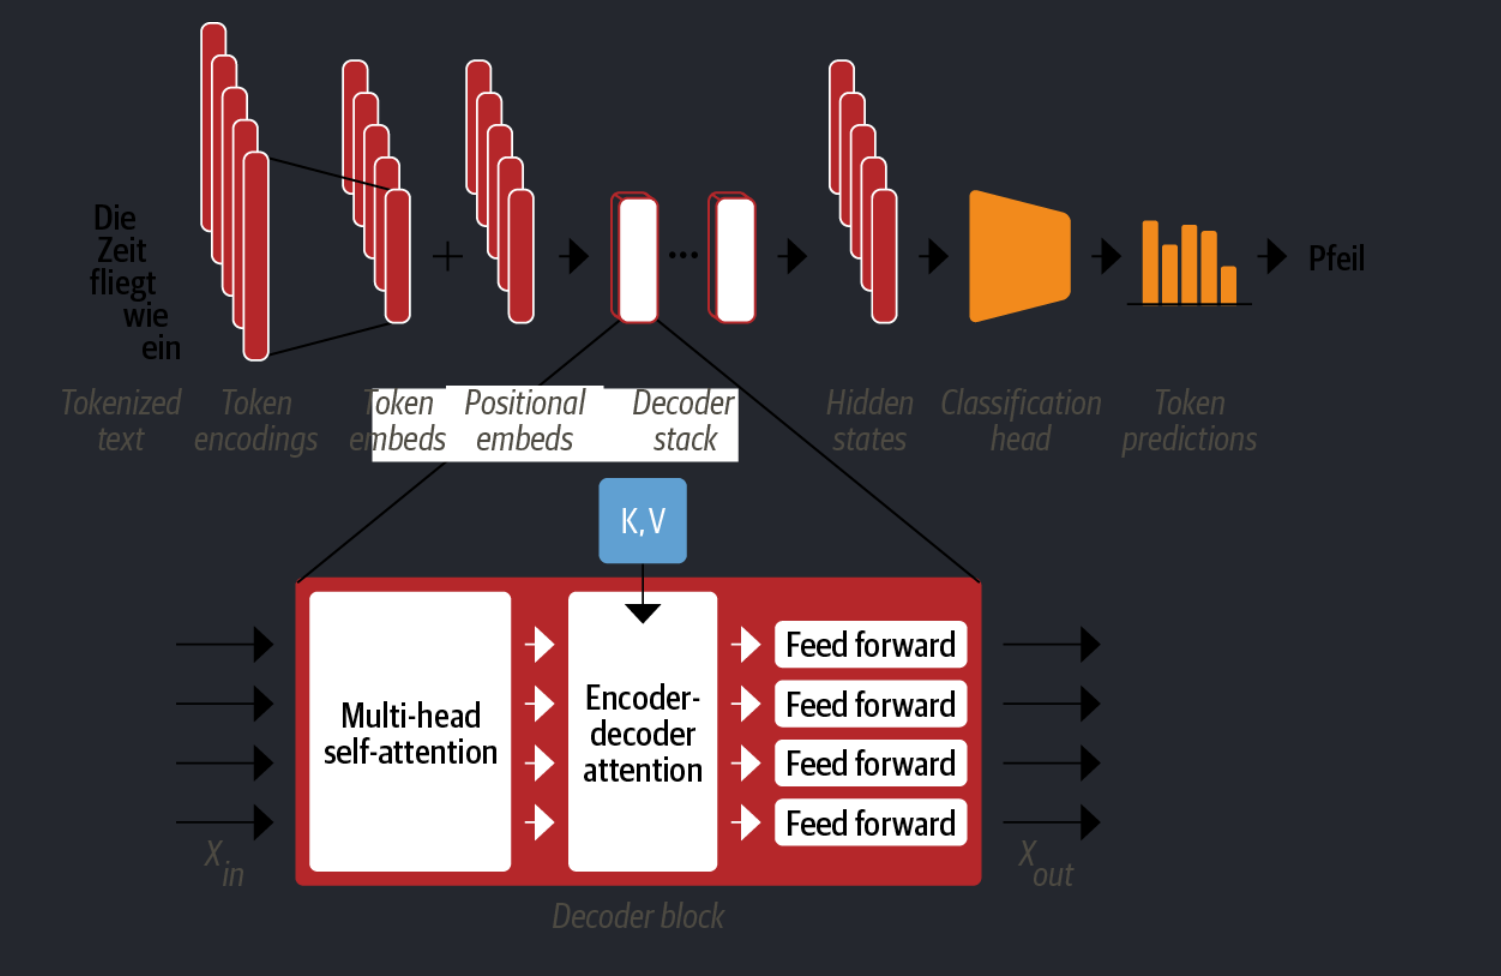

In [53]:
seq_len = inputs.input_ids.size(-1)

mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)

In [54]:
mask.shape

torch.Size([1, 9, 9])

In [55]:
scores.masked_fill(mask == 0, -float("inf"))

tensor([[[28.6336,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf],
         [-0.2074, 26.7878,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf],
         [ 0.4428,  0.7501, 27.8748,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf],
         [ 1.0407,  0.3764,  0.2776, 25.8447,    -inf,    -inf,    -inf,
             -inf,    -inf],
         [ 0.5038,  0.1975, -0.1295, -1.5390, 27.9140,    -inf,    -inf,
             -inf,    -inf],
         [ 0.5750,  0.4311, -2.0315, -0.1611, -0.1444, 28.7770,    -inf,
             -inf,    -inf],
         [-1.4437, -0.9927,  1.3725, -1.0155, -1.4691, -0.5760, 29.2485,
             -inf,    -inf],
         [ 0.1008, -1.4380,  0.8054, -0.3110,  1.7360,  0.6492,  1.5967,
          28.9063,    -inf],
         [-0.4764,  1.6803,  1.0309,  0.4302,  1.9693,  0.2327, -0.8820,
          -0.7271, 25.1035]]], grad_fn=<MaskedFillBackward0>)

In [56]:
query.size()

torch.Size([1, 9, 768])

In [57]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # query, key, value shape # (batch_size, seq_len, N_DIM) (1, 9, 768)
    dim_k = key.size(-1)
    # dim_k = N_DIM (768)

    ## Batch Matrix Product torch.bmm ##
    ## Does matmul over matrices of (batch_size, seq_len, n_dim) * (batch_size, n_dim, seq_len) ##
    ## Result matrix product on a batch data: (batch_size, seq_len, seq_len) [Self-Attn] ##
    ## Division by sqrt(K) to ensure values are not extreme before applying softmax ##
    
    ## scaled dot product
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k) ## (batch_size, seq_len, seq_len)

    seq_len = scores.size(-1)

    mask_arr = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)

    if mask is not None:
        ## Scaled Dot Product in Causal Self Attention ##
        scores = scores.masked_fill(mask_arr == 0, float("-inf"))

    
    ## Attention Weights ##
    weights = F.softmax(scores, dim=-1) ## (batch_size, seq_len, seq_len)

    ## Value vector shape : (batch_size, seq_len, N_DIM)
    return weights.bmm(value) ## (batch_size, seq_len, N_DIM)

In [58]:
key.transpose(1,2).shape

torch.Size([1, 768, 9])

In [59]:
scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)

In [60]:
scaled_dot_product_attention(query, key, value)

tensor([[[-0.6132, -1.5559,  0.3702,  ..., -0.4792, -0.1516,  0.9765],
         [-0.1516, -1.4767,  1.2208,  ...,  1.8622, -1.4928,  1.6033],
         [ 0.1205, -1.6588,  0.7436,  ...,  0.5427, -2.6855,  1.1486],
         ...,
         [-0.1676, -0.0436, -1.5429,  ...,  0.1549, -0.5740, -0.0233],
         [-0.9426, -0.8717,  0.3226,  ...,  1.8793, -1.3218, -0.6118],
         [ 0.9385, -1.2912,  1.3972,  ...,  0.1655,  0.4447,  0.5908]]],
       grad_fn=<BmmBackward0>)

In [61]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)

In [62]:
weights = F.softmax(scores.masked_fill(mask == 0, -float("inf")), dim=-1)

### Building Decoder Layer

1. Encoder & Decoder Layer both share same embedding Layer


a. Causal Attention

b. Cross Attention

c. Feed Forward

In [63]:
class AttentionHead(nn.Module):

    def __init__(self, embed_dim , head_dim, mask=None):
        super().__init__()

        ## Projection of Embedding / Hidden State in Query, Key, Value Matrix
        ## nn.Linear is doing matrix multiplication
        self.q = nn.Linear(embed_dim, head_dim) # Query Weights
        self.k = nn.Linear(embed_dim, head_dim) # Key Weights
        self.v = nn.Linear(embed_dim, head_dim) # Value Weights

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(self.q(hidden_state),
                                                    self.k(hidden_state),
                                                    self.v(hidden_state),
                                                    mask=mask)
        return attn_outputs

In [64]:
class CrossAttentionHead(nn.Module):


    def __init__(self, embed_dim, head_dim, encoder_hidden_state):
        super().__init__()
        ## Projection of Embedding / Hidden State in Query, Key, Value Matrix
        ## nn.Linear is doing matrix multiplication
        
        self.q = nn.Linear(embed_dim, head_dim) # Query Weights
        self.k = nn.Linear(embed_dim, head_dim) # Key Weights
        self.v = nn.Linear(embed_dim, head_dim) # Value Weights

        self.encoder_state = encoder_hidden_state

    
    def forward(self, hidden_state):

        attn_outputs = scaled_dot_product_attention(self.q(hidden_state),
                                                    self.k(self.encoder_state),
                                                    self.v(self.encoder_state))

        return attn_outputs

In [65]:
class MultiCrossAttention(nn.Module):
    
    def __init__(self, config, encoder_hidden_state):
        super().__init__()
        
        embed_dim = config.hidden_size ## 768 Embedding Dimensions
        num_heads = config.num_attention_heads ## 12 Heads
        head_dim = embed_dim // num_heads ## 64 

        self.cross_attn_heads = nn.ModuleList(
            [CrossAttentionHead(embed_dim, head_dim, encoder_hidden_state) for _ in range(num_heads)]
        )

        self.output_linear = nn.Linear(embed_dim, embed_dim)

    
    def forward(self, hidden_state):

        x = torch.cat([h(hidden_state) for h in self.cross_attn_heads], dim=-1)
        x = self.output_linear(x)

        return x


In [66]:
class MultiHeadAttention(nn.Module):
    ## represent params for bert uncased
    
    def __init__(self, config, mask=None):
        super().__init__()

        embed_dim = config.hidden_size ## 768 Embedding Dimensions
        num_heads = config.num_attention_heads ## 12 Heads
        head_dim = embed_dim // num_heads ## 64 

        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim, mask) for _ in range(num_heads)]
            )
        
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):

        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)

        return x

In [67]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)

        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)


    def forward(self, x):
        
        # x is hidden state from previous Encoder Block #
        hidden_state_norm = self.layer_norm_1(x)

        # self attention on normalised hidden state
        x_attn = self.attention(hidden_state_norm)

        # Apply skip connection to `x_attn` with `hidden_state_norm`
        layer_norm_mha_skip_connect = x + x_attn

        # Applying 2nd layer normalisation

        layer_norm_pre_ffcn = self.layer_norm_2(layer_norm_mha_skip_connect)

        ffcn_output = self.feed_forward(layer_norm_pre_ffcn)

        return ffcn_output

In [68]:
class TransformerEncoder(nn.Module):

    def __init__(self, config):

        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        x = self.embeddings(x)

        for layer in self.layers:
            x = layer(x)

        return x

(torch.Size([1, 9, 768]), torch.Size([1, 9, 768]))

In [69]:
class TransformerDecoderLayer(nn.Module):

    def __init__(self, config, encoder_hidden_state):
        super().__init__()

        self.layer_norm_causal_attn = nn.LayerNorm(config.hidden_size)
        self.layer_norm_cross_attn = nn.LayerNorm(config.hidden_size)
        self.layer_norm_ffcn = nn.LayerNorm(config.hidden_size)

        ## causal attention ##
        self.causal_attention = MultiHeadAttention(config, mask=True)

        ## cross attention ##
        self.cross_attention = MultiCrossAttention(config, encoder_hidden_state)

        ## feed forward
        self.feed_forward = FeedForward(config)

    
    def forward(self, x):
        
        # x is hidden state from previous Encoder Block #
        hidden_state_norm = self.layer_norm_causal_attn(x)

        # self causal attention on normalised hidden state
        x_attn = self.causal_attention(hidden_state_norm)

        # Apply skip connection
        layer_norm_mha_skip_connect = x + x_attn

        # Applying 2nd layer normalisation

        layer_norm_cross_attn = self.layer_norm_cross_attn(layer_norm_mha_skip_connect)

        x_cross_attn = self.cross_attention(layer_norm_cross_attn)

        # Applying 3rd layer norm 

        layer_norm_ffcn = self.layer_norm_ffcn(x_cross_attn + layer_norm_mha_skip_connect)

        ffcn_output = self.feed_forward(layer_norm_ffcn)

        return ffcn_output

In [70]:
inputs

{'input_ids': tensor([[7975, 4625, 1996, 2395, 2138, 2009, 2001, 2205, 6015]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [71]:
token_input_ids = inputs.input_ids


encoder_block = TransformerEncoder(config)
encoder_hidden_state = encoder_block(token_input_ids)

In [72]:
encoder_hidden_state.shape

torch.Size([1, 9, 768])

In [73]:
decoder = TransformerDecoderLayer(config, encoder_hidden_state)

In [ ]:
class TransformerEncoder(nn.Module):

    def __init__(self, config):

        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        ## x as input to embedding is position_ids
        x = self.embeddings(x)
        ## x as output of embedding is (SEQ_LEN, N_DIM) Torch 
        
        for layer in self.layers:
            x = layer(x)

        return x

In [228]:
class TransfomerDecoderProjection(nn.Module):

    def __init__(self, config):

        super().__init__()
        
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.linear_transform = nn.Linear(config.hidden_size, config.vocab_size) ## (768 , 30522)


    def forward(self, decoder_output):

        logits = self.linear_transform(self.dropout(decoder_output))

        prob_matrix = F.softmax(logits, dim=-1)[:, -1, :] ## last token softmax 

        token_id = prob_matrix.argmax(dim=-1).unsqueeze(0)

        return token_id

In [ ]:
class TransformerDecoder(nn.Module):

    _DECODER_START_VOCAB_ID_ = torch.tensor([[789]])
    _DECODED_POSITON_IDX_ = _DECODER_START_VOCAB_ID_

    def __init__(self, config, encoder_hidden_state):

        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerDecoderLayer(config, encoder_hidden_state)
                                     for _ in range(config.num_hidden_layers)])
        
        self.decoder_projection = TransfomerDecoderProjection(config)
        
    def forward(self, x):
        pass

In [199]:
config.vocab_size

30522

In [74]:
decoder_layer_output = decoder(query[:, 0:4,:])

In [75]:
decoder_layer_output.shape

torch.Size([1, 4, 768])

In [207]:
linear_transform = nn.Linear(config.hidden_size, config.vocab_size)
dropout = nn.Dropout(config.hidden_dropout_prob)

In [212]:
pre_softmax = linear_transform(dropout(decoder_layer_output))

In [214]:
pre_softmax.shape

torch.Size([1, 4, 30522])

In [213]:
pre_softmax

tensor([[[ 0.0449,  0.0579,  0.0103,  ...,  0.0261, -0.1572,  0.0336],
         [-0.0886,  0.1660,  0.1555,  ..., -0.0965,  0.0567,  0.1196],
         [ 0.0063,  0.0335,  0.2613,  ..., -0.1703,  0.0502, -0.0201],
         [ 0.0253, -0.0519,  0.0415,  ..., -0.1739, -0.2234, -0.0055]]],
       grad_fn=<ViewBackward0>)

In [220]:
F.softmax(pre_softmax, dim=-1)

tensor([[[3.4017e-05, 3.4463e-05, 3.2861e-05,  ..., 3.3384e-05,
          2.7794e-05, 3.3635e-05],
         [2.9751e-05, 3.8381e-05, 3.7980e-05,  ..., 2.9518e-05,
          3.4404e-05, 3.6638e-05],
         [3.2713e-05, 3.3617e-05, 4.2217e-05,  ..., 2.7417e-05,
          3.4181e-05, 3.1862e-05],
         [3.3340e-05, 3.0864e-05, 3.3886e-05,  ..., 2.7320e-05,
          2.6000e-05, 3.2329e-05]]], grad_fn=<SoftmaxBackward0>)

In [221]:
vv= F.softmax(pre_softmax, dim=-1)[:, -1,:]

In [227]:
vv.argmax(dim=-1).unsqueeze(0)

tensor([[27886]])

In [225]:
input_ids

tensor([[7975, 4625, 1996, 2395, 2138, 2009, 2001, 2205, 6015]])